# C1 Galaxy Cluster Injection


In this notebook we process the rendered galaxy catalogs using the sextractor software, to obtain a catalog of  photometric detections.


## Objectives

    1 Learn to use the synthetic package to wrap sextractor
 


## Setup

This notebook relies on the:

    * synthetic package & dependencies
    
    * prepared curated DC2 cutouts


## Output

    * source extractor catalog
    
    
The output files are placed in the `./data/` folder


## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [7]:
import fitsio as fio
import numpy as np
import pandas as pd
import pickle as pickle
import copy
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.cosmology as cosmology

import images # package from erin sheldon

import synthetic.tools as tools
import synthetic.render.frame as frame
import synthetic.render.render as render


pixel_scale = 0.2

*** Important *** set the `nprocess` value to the amount of CPU cores you are willing or allowed to use for this notebook

please consider your local server, e.g. don't run heavy calculations on public login nodes

In [8]:
nprocess = 4

In [9]:
# output path for mock image, be sure to place it into a folder where you can write a few GBs of files 
out_path = "./data/"

# Create a rendered image we are going to work on

This is largely identical to the B1 tutorial

Now we load an arbitrary chunk of DC2, in this case orderedd by a list of healpix pixel cutotuts.

In [6]:
table_path = './data/refdata/curated_table.h5'
table = pd.read_hdf(table_path, key="data")

ra_cen = 50.64516228577292
dec_cen = -40.228830895890404

mock_catalog_path = './data/refdata/curated_mock_catalog.h5'
mock_catalog = pd.read_hdf(mock_catalog_path, key="data")

# Creating a deeper, detection image

source detection is traditionally done on coadded images, even when shear estimation is performed per-frame for greater performance.

For this reason, unlike in B1, B2, B3, we are going to create a single, deeper, detection frame

In [37]:
band = 'i'
name = out_path + 'test_canvas_' + band
print(name)
fr_field = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=1., canvas_size=1000, config_se='data/configs/config.sex')
fr_field.render(nprocess=nprocess) 

data/test_canvas_i
starting postage stamp calculations in 100 processes


after rendering, we can run sextractor, and load the results as

In [38]:
fr_field.extract()

sex data/test_canvas_i.fits -c data/configs/config.sex -CATALOG_NAME data/test_canvas_i_cat.fits -CHECKIMAGE_NAME data/test_canvas_i_seg.fits


here we have access to the sextractor catalog, and the segmentation map

In [52]:
scat = fr_field.scat.copy()
seg = fio.read("./data/test_canvas_i_seg.fits")

In [53]:
arr = fr_field.canvas.array.copy()

And now we can plot the image, along with the positions of the detected sources

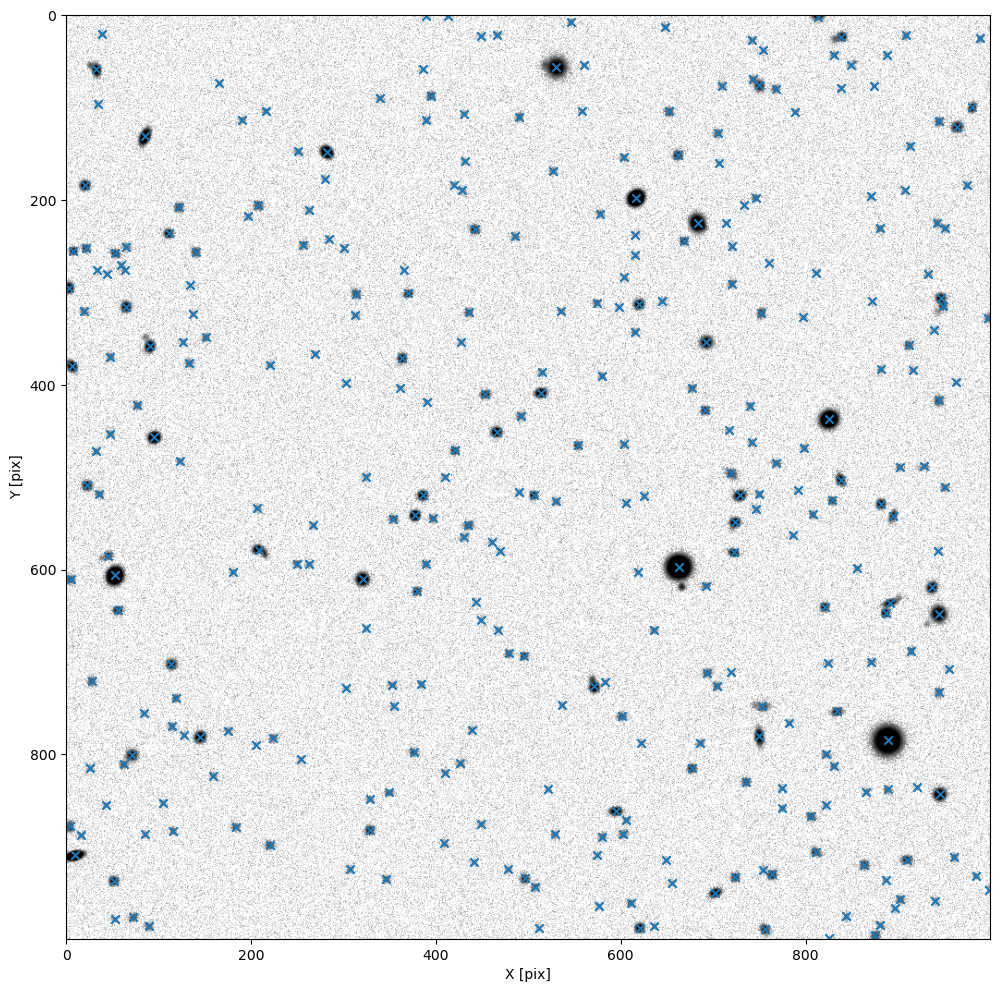

In [65]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

ax.imshow(images.asinh_scale(arr*0.2, 0.3) * 4, cmap=plt.cm.gray_r)
ax.scatter(scat['X_IMAGE'] - 1, scat['Y_IMAGE'] - 1, marker="x")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("./data/test_se.png")

and also plot the so called segmentation maps, which are estimates of the pixels belonging to each source 

The color coding is related to the ID number of each source. As can be seen the detection progresses from upper left to lower right, row by row, left to right.

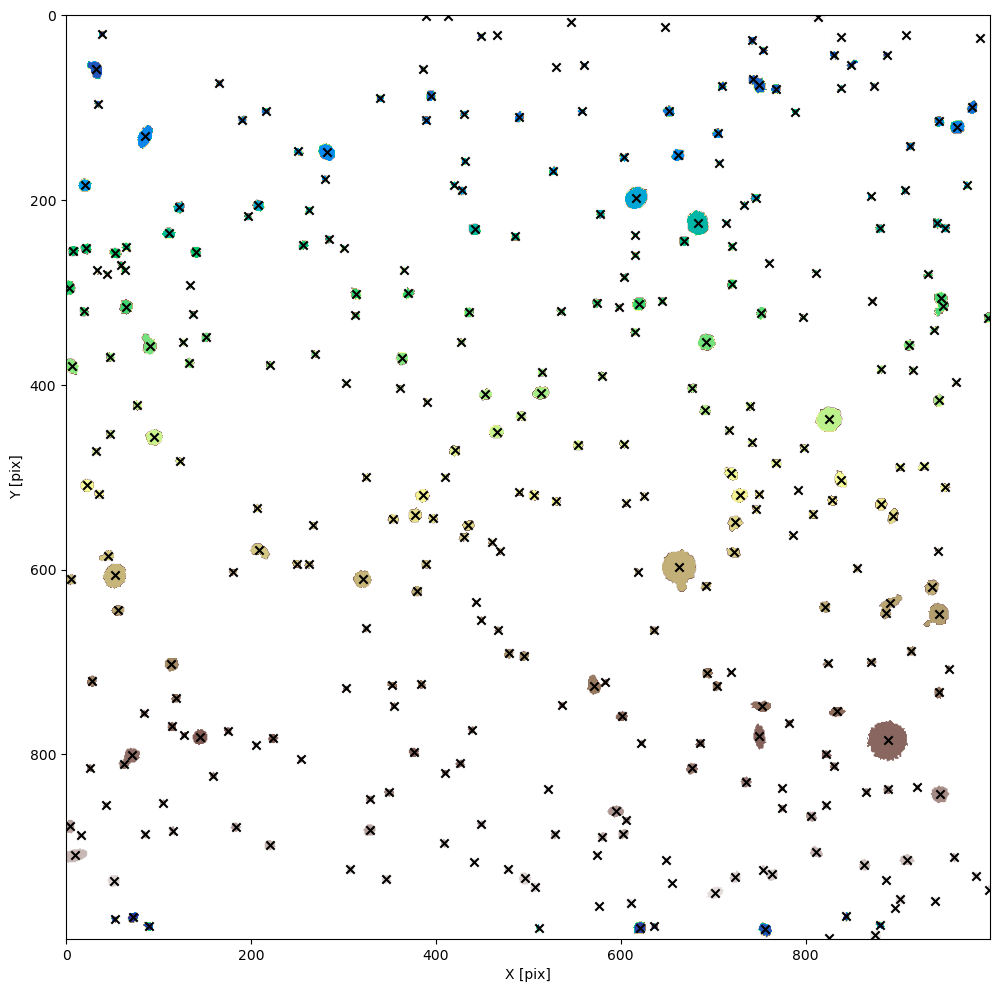

In [66]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

ax.imshow(seg, cmap=plt.cm.terrain_r)
ax.scatter(scat['X_IMAGE'] - 1, scat['Y_IMAGE'] - 1, marker="x", c="black")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

fig.savefig("./data/test_se_segmap.png")